<a href="https://colab.research.google.com/github/harnalashok/general/blob/master/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 06th Dec, 2021
#
# Ref: github:
#      1. https://github.com/marcopeix/time-series-analysis/tree/master/Advanced%20modelling
#      2. https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b
#
# Objective: Apply Seasonal ARIMA (SARIMA) on a 
#            time-series and find the best set 
#            of parameters semi-automatically.
#
# Data set is here:
#  https://github.com/harnalashok/general/blob/master/jj.csv
#

# SARIMA 
Semi-automatically determine best sets of (p,d,q) and (P,D,Q).<br>
There are two criteria for testing which model is the best. One criteria is of lowest 'rmse' and another one is lowest 'AIC' score. <br>
In our code below, we use *'AIC'* score to label the best model.

Steps are
> 1. Read data. Let it be *'df'*. Make a copy of *'df'* for processing in steps below. Let this copy be *'dx'*.
> 2. Check visually what degree of differences ('*d*') will remove trend from *dx*. Modify *'dx'* accordingly (ie remove trend from *'dx'*). 
> 3. Check visually what difference (*'D'*) can remove seasonality from *'dx'*. Modify *'dx'* accordingly (ie remove seasonality).
> 4. Statistically test if after steps (2) and (3), the amended *'dx'* is stationary.
> 5. If so, use the unmodified data (df) above in the function defined in **Section H** below and in the code-lines written thereafter to get the best model and make forecasts. 

This example uses log(df) instead of df. But, this is because data has exponential trend.

In [ ]:
# Last amended: 5th Dec, 2021
# Ref: github:
#      1. https://github.com/marcopeix/time-series-analysis/tree/master/Advanced%20modelling
#      2. https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

In [1]:
# 1.0 For plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
# 1.1 For Seasonal ARIMA(p,d,q)(P,D,Q)
from statsmodels.tsa.statespace.sarimax import SARIMAX
# 1.2 Another model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1.3 For testing stationarity
from statsmodels.tsa.stattools import adfuller

# 1.4 For graphs
import matplotlib.pyplot as plt

# 1.5 For getting loop-progress
from tqdm import tqdm_notebook

# 1.6 Our normal libraries
import numpy as np
import pandas as pd

# 1.7 For creating a grid of parameters
#     to be tested
from itertools import product

# 1.8 Misc
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 1.9
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## A. Mount gdrive

In [3]:
# 2.0
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## B. Johnson and Johnson Quaterly Earnings

In [4]:
# 3.0  Read data:
data = pd.read_csv('/gdrive/MyDrive/Colab_data_files/ARIMA/SARIMA/jj.csv')
data.head()
data.shape   # (84,2)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


(84, 2)

## C. Explore data

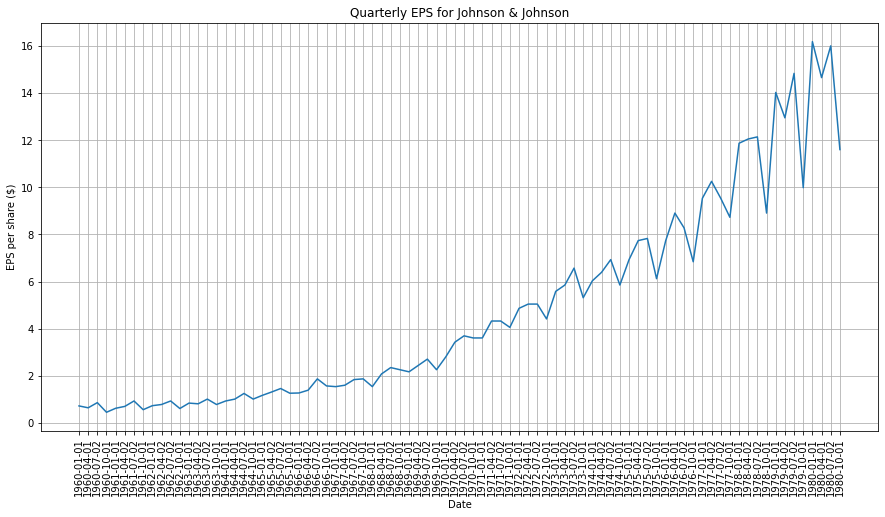

In [5]:
# 3.1 Plot data
# 3.1.1 Set dimensions for figure
plt.figure(figsize=[15, 7.5]);

# 3.1.2 Plot line plot
plt.plot(data['date'], data['data']);

# 3.1.3 Give a title
plt.title('Quarterly EPS for Johnson & Johnson');

# 3.1.4 X and Y-labels
plt.ylabel('EPS per share ($)');
plt.xlabel('Date');

# 3.1.5 Show x-ticks
plt.xticks(rotation=90);

# 3.1.6 Show grid
plt.grid(True);
plt.show();

## D. ACF and PACF plots

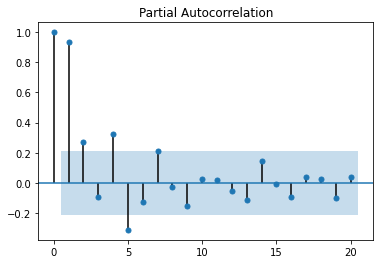

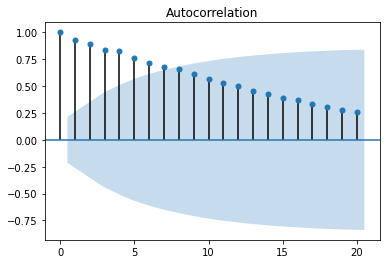

In [6]:
# 4.0 Plot PACF and ACF
#     with raw unprocessed data
#     Apparently it is AR(2)

plot_pacf(data['data']);
plot_acf(data['data']);

## E. Test for stationarity

In [7]:
# 5.0 Augmented Dickey-Fuller test
#     For stationarity

# As p value is very large, data is NOT
#  stationary. Null hypothesis of data
#   being non-stationary stands

ad_fuller_result = adfuller(data['data'])

# 5.1 Results of test:

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574735
p-value: 1.0


In [8]:
# 5.1 As there is expondnetial trend,
#      take the log difference to make
#        data stationary

# 5.1.1 Log of data
data['data'] = np.log(data['data'])

# 5.1.2 Save this dataset for subsequent use:
df = data.copy()

## F. Exploring df

### df has seasonality
But trend can be eliminated after 1st difference

In [9]:
## Let us see if the df dataset can be made
#  staionary. If so, for what difference?

# 5.1.3 Take Ist difference of log-data
#       diff() is pandas method
n = 1   # Just take first difference
#       n = 2 means two differences
data['data'] = df['data'].diff(n).copy()

# 5.1.4 Note because of first difference
#        the 1st row has NaN value
#        we can drop it for plotting

data.head()

,date,data
0,1960-01-01,NaN
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684


In [10]:
# 6.0 Drop the first row having a NaN
#      Drop row at index = 0
data = data.drop(data.index[0])
data.head()

,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233


<Figure size 1080x540 with 0 Axes>

Text(0.5, 1.0, 'Log Difference of Quarterly EPS for Johnson & Johnson')

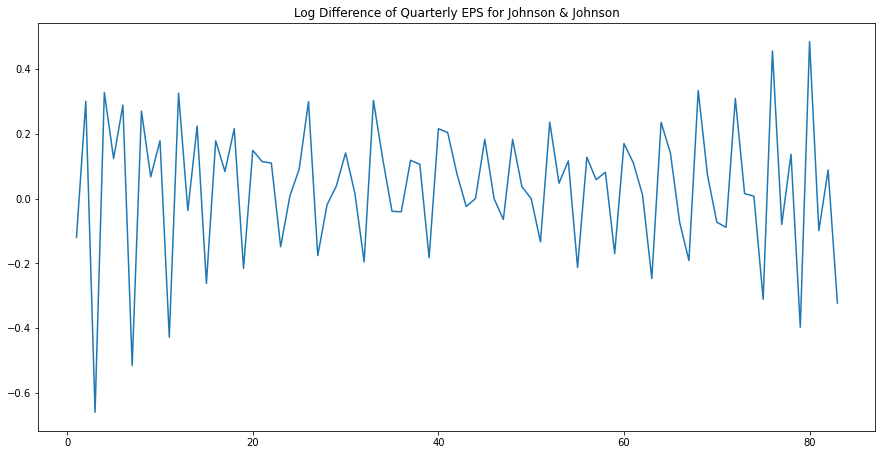

In [11]:
# 6.1 Plot the line plot
#     Line plot shows no trend. Just seasonality

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [12]:
# 6.2 We observe that season is of 4-periods,
#      So perform seasonal differencing
#      after every 4-periods
n = 4
data['data'] = data['data'].diff(4)

# 6.3 First 4 rows now have NaNs
data.head()

,date,data
1,1960-04-01,NaN
2,1960-07-02,NaN
3,1960-10-01,NaN
4,1961-01-01,NaN
5,1961-04-02,0.242778


In [13]:
# 6.4 Drop the 1st four rows bein NaN
#     Else we cannot perform Dickey-Fuller test

data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,data
0,1961-04-02,0.242778
1,1961-07-02,-0.011834
2,1961-10-01,0.144006
3,1962-01-01,-0.057351
4,1962-04-02,-0.056093


<Figure size 1080x540 with 0 Axes>

Text(0.5, 1.0, 'Log Difference of Quarterly EPS for Johnson & Johnson')

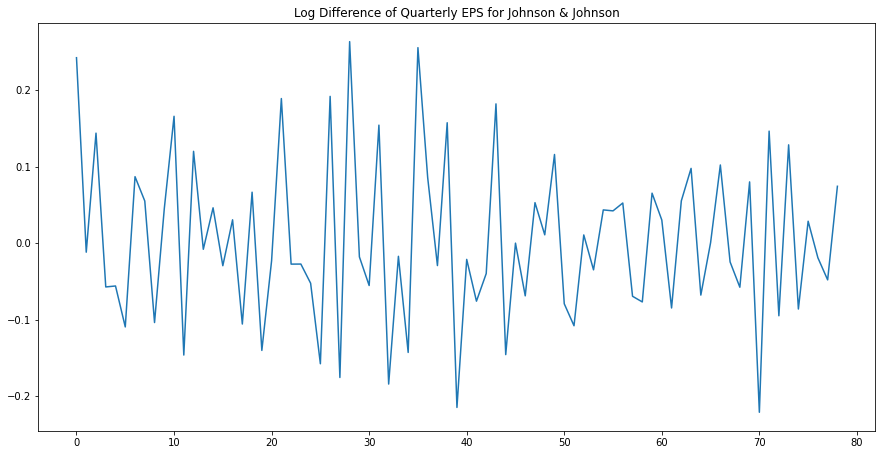

In [14]:
# 6.5 Plot again the data
#     This time it is no trend and no seasonality:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

## G. Test again for stationarity

In [15]:
# 7.0 Once again perform augmented Dickey-Fuller test
#     p value indicates result is significant.
#     Null hypothesis is rejected. Data is now
#     stationary
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.6308051099142675
p-value: 5.721578695136043e-09


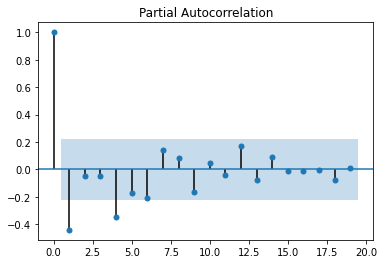

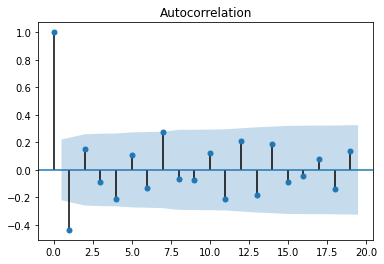

In [16]:
# 7.1 Finally have a look at the 
#     PACF and ACF plots:

plot_pacf(data['data']);
plot_acf(data['data']);

From the above we conclude:
> Perform log of original data<br>
> Our this log data is df<br>
> df can be made stationary by 1st difference and 4th difference.

## H. Function to discover best parameters

We write a function that given a grid of points, discovers that point in the grid which will minimize rmse and AIC.
In fact, this function returns AIC value for all grid points. You have to manually select that grid point for which AIC is minimum. 

This function is very simple. Loop over all points in the grid of parameters. For every point in the grid, create SARIMA model and calculate AIC score. Record the grid-point and AIC score in a dataframe. Finally print the dataframe. The dataframe is arranged in ascending order of AIC score--implying thereby the set of parameters in the very first row will give the best model.

In [17]:
# 8.0 Define the function to test all parameters in a list:

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - Differences needed to remove trend
        D - Differences needed to remove seasonality
        s - length of season
        exog - the exogenous variable (our dataset)
    """
    # 8.1 Start with empty results list
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            # 8.2 For every grid point, create a model
            model = SARIMAX(
                             exog,
                             order=(param[0], d, param[1]),
                             seasonal_order=(param[2], D, param[3], s)
                            ).fit(disp=-1)
        except:
            continue
            
        # 8.3 For this model, get AIC value
        aic = model.aic
        # 8.4 Append the grid point and aic value to results
        results.append([param, aic])

    # 8.5 Finally create a dataframe from results[]    
    result_df = pd.DataFrame(results)
    # 8.6 Assign column names
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #8.7 Sort in ascending order, lower AIC is better
    #     So the top-most grid-point is our parameter set
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
# 9.0 Create a range of possible values
#      that p,d,q an P,D and Q can have:

# 9.1 p can have any value from 0 to 3
p = range(0, 4, 1)

# 9.2 d can only be 1
d = 1

# 9.3 q can have value from 0 to 3
q = range(0, 4, 1)

# 9.4 P can have value from 0 to 3
P = range(0, 4, 1)

# 9.5 D can only be 1
D = 1

# 9.6 Q can assume any value between 0 and 3
Q = range(0, 4, 1)

# 9.7 Seasonality is of 4 periods
s = 4

### Grid of points

In [21]:
# 10.0 Create a list of parameter-sets:
#      We create a grid of points:

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

# 10.1 How many sets of parameters and which ones?
print(len(parameters_list))  # 256 sets
parameters_list[:10]   # Show just 10 grid poitns

256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1)]

In [22]:
# 11.0 Finally call the function:
result_df = optimize_SARIMA(
                            parameters_list,  # Grid
                            1,          # d
                            1,          # D
                            4,          # seasonal period
                            df['data']   # exogenous variable
                            )
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 2, 1)",-151.272926
1,"(0, 1, 1, 0)",-150.913569
2,"(0, 1, 0, 1)",-150.752930
3,"(0, 3, 0, 1)",-149.425152
4,"(0, 1, 3, 1)",-149.380857
...,...,...
251,"(0, 0, 3, 1)",-124.472710
252,"(0, 0, 0, 2)",-124.413462
253,"(0, 0, 1, 1)",-124.364825
254,"(0, 0, 0, 0)",-124.068515


## I. Create now the best model

In [23]:
# 11.1 Our best_model is with parameters: (p,q,P,Q) = (0,1,2,1) 
#      OR: p=0, d=1, q=1 AND P =2, D =1, Q = 1
# 
best_model = SARIMAX(
                     df['data'],
                     order=(0, 1, 1),
                     seasonal_order=(2, 1, 1, 4)  # 4: seasoality
                     ).fit(dis=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                              data   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 4)   Log Likelihood                  80.636
Date:                           Sun, 05 Dec 2021   AIC                           -151.273
Time:                                   23:43:34   BIC                           -139.426
Sample:                                        0   HQIC                          -146.527
                                            - 84                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6595      0.102     -6.477      0.000      -0.859      -0.460
ar.S.L4       -1.2647      0.175     -7.226

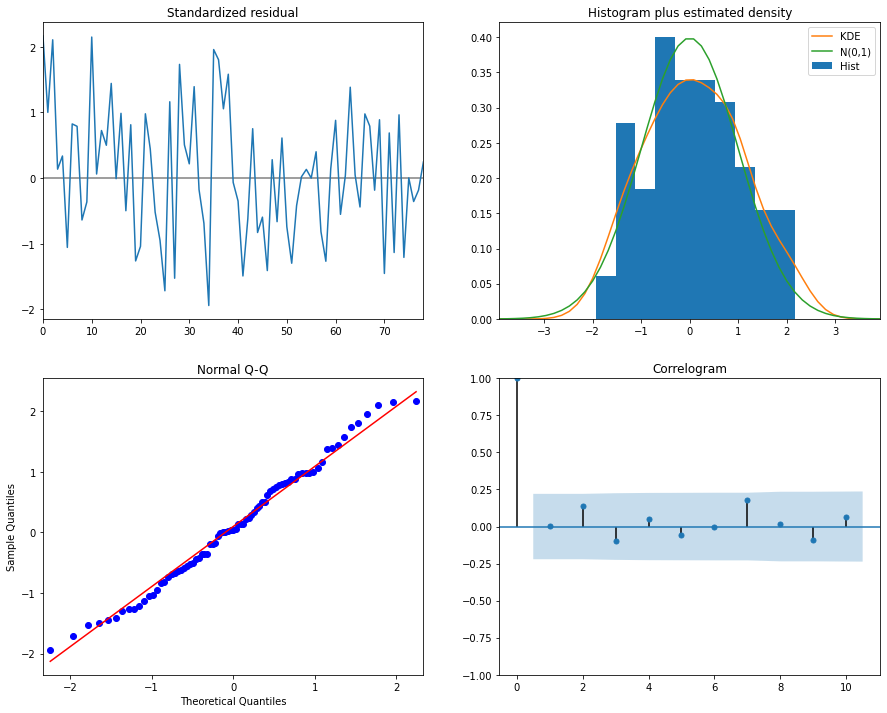

In [24]:
# 11.2
best_model.plot_diagnostics(figsize=(15,12));

## Making forecast

In [26]:
# 12.0 Forecast for existing periods:

n=4   # Seasonality
d = 1 # Differencing

# 12.1 Here is the column that contains
#       predicted values as per best model 
#        Top 'n+d' rows will have NaN:

df['arima_model'] = best_model.fittedvalues
df['arima_model'][:n+d] = np.NaN    # 4 +1 for S and d
df.head(6)

,date,data,arima_model
0,1960-01-01,-0.342490,NaN
1,1960-04-01,-0.462035,NaN
2,1960-07-02,-0.162519,NaN
3,1960-10-01,-0.820981,NaN
4,1961-01-01,-0.494296,NaN
5,1961-04-02,-0.371064,-0.613841


In [28]:
# 12.2 Make forecast for beyond

forecastPeriod = 8
forecast = best_model.predict(
                               start=df.shape[0],
                               end=df.shape[0] + forecastPeriod   
                              )


# 12.2.1
forecast

84    2.894099
85    2.826459
86    2.929586
87    2.577385
88    3.047099
89    2.946986
90    3.049721
91    2.706813
92    3.157784
dtype: float64

In [ ]:
# 12.3 Append this forecast to existing results:

forecast = df['arima_model'].append(forecast)

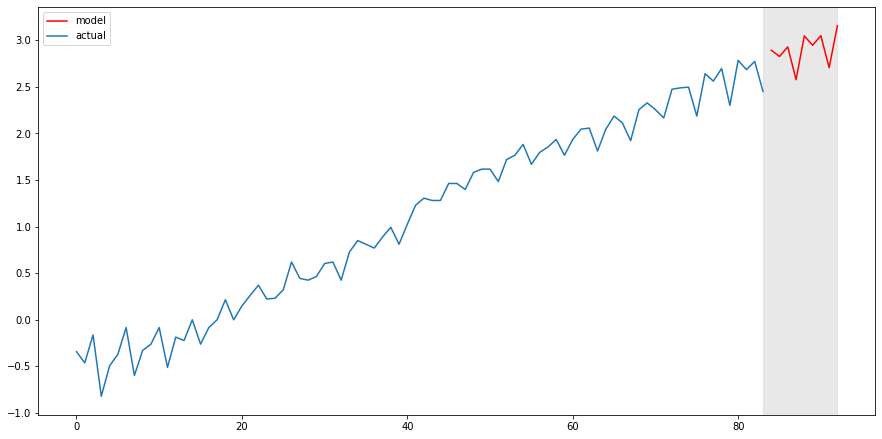

In [31]:
# 12.4 And now plot the complete data:

plt.figure(figsize=(15, 7.5));

# 12.5 Just the forecast:

plt.plot(
           forecast,
           color='r',
           label='model'
          );

# 12.6 Also the data:

plt.plot(
           df['data'],
           label='actual'
        );


# 12.7 Draw two vertical lines to indicate
#       the forecast period. Color this span

plt.axvspan(
             df.index[-1],         # Begin span
             forecast.index[-1],   # end span
             alpha=0.5,            # Transperancy
             color='lightgrey'     # color of span
            );

# 12.8 Legend
plt.legend();

plt.show();

Following code is not examined

## Exponential Smoothing (Holt-Winters) 
This code has not been examined

In [ ]:
data = pd.read_csv('jj.csv')
data.shape

(84, 2)

In [ ]:
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [ ]:
model = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

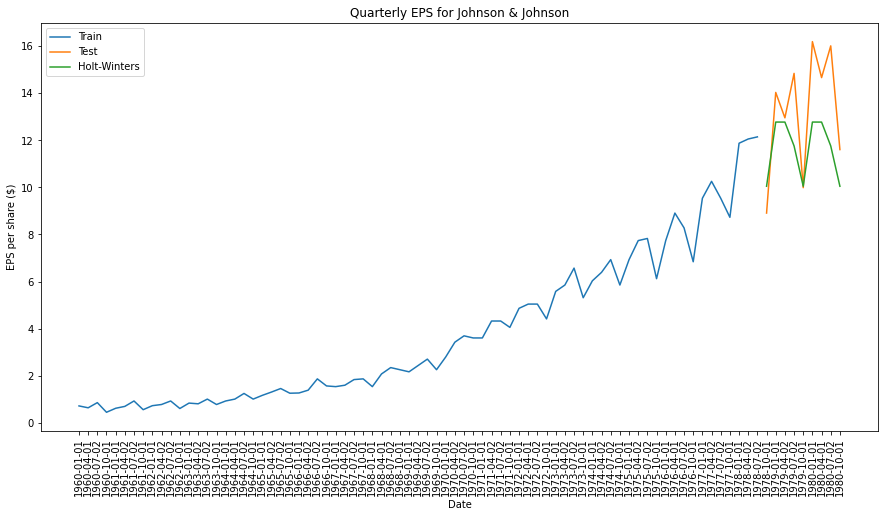

In [ ]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train['data'], label='Train')
plt.plot(test['date'], test['data'], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()